In [2]:
print("Welcome to ML Project - California Housing")

Welcome to ML Project - California Housing


We need to ensure that Python version >= 3.7

In [6]:
import sys
assert sys.version_info >= (3,7)

Also, check for scikit-learn > 1.0.1

In [8]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Our task is to predict the median house values in Californian districts, given a number of features from these districts.

I have already downloaded the data, but you can get. it from: https://github.com/ageron/data/raw/main/housing.tgz

In [10]:
import pandas as pd

housing = pd.read_csv("../data/housing.csv")

In [11]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Here we notice that in total_bedrooms, 207 districts are missing, we will take care of this later

In [14]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


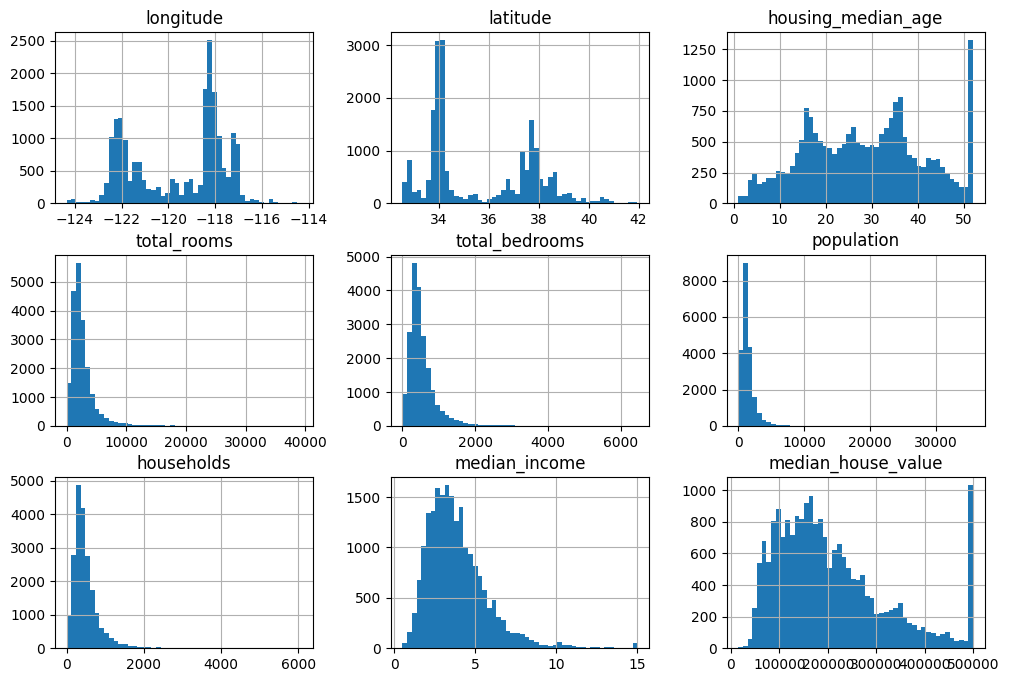

In [16]:
import matplotlib.pyplot as plt

housing.hist(bins = 50, figsize = (12, 8))
plt.show()

- Median income is represented roughly in tens of thousands of dollars, so 3 means $30,000 income.
- The median house value and housing median age have also been capped, if you need precise predictions collect proper labels for them or remove those districts from the training and test set since the system should not be poorly evaluated for values exceeding the capped values.
- Some histograms are right skewed meaning they extend much farther to the right of the median than to the left, we will transform these into more symmetrical and bell shaped distributions later.

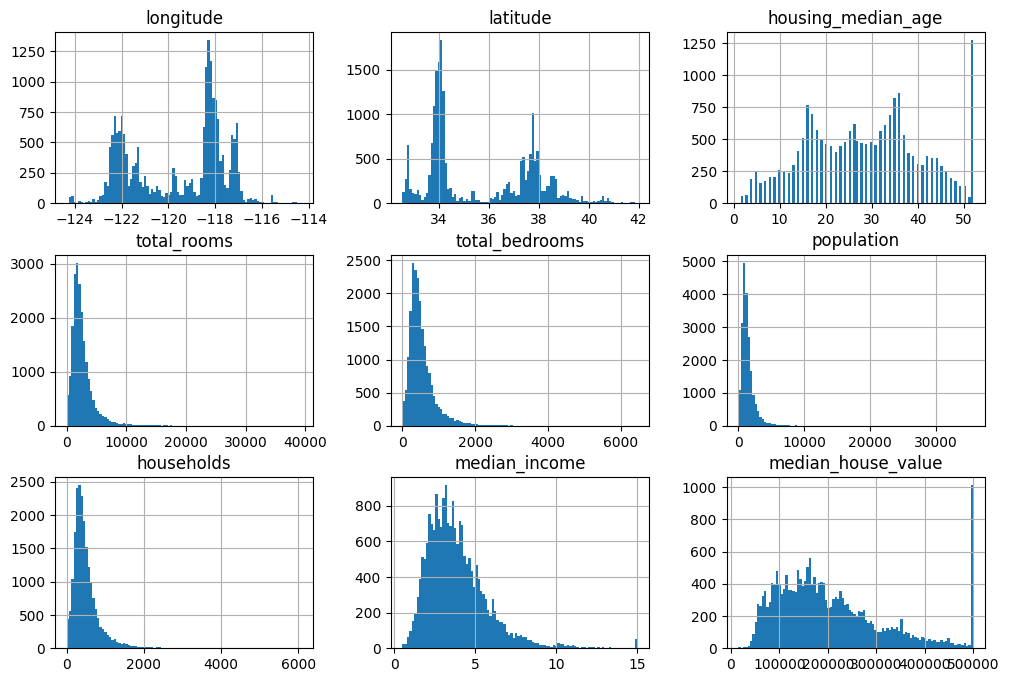

In [17]:
housing.hist(bins = 100, figsize = (12,8))
plt.show()

Let us create a test set, but first without the train_test_split feature

In [24]:
np.random.seed(42) # to ensure the output stays same on each run

In [25]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [26]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [27]:
len(test_set)

4128

Now, let us use the sklearn train_test_split

In [28]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [29]:
len(test_set)

4128

Now, let us understand stratified sampling: 
The population is divided into homogenous groups called strata, and the right number of instances are sampled from each stratum to ensure that the test set is representative of the actual population.

In this case, we have t=been told that median income is a very important feature, so we want to ensure proper sampling from it.

Let us put the income in categories

In [30]:
housing['income_cat'] = pd.cut(housing["median_income"],
                            bins = [0,1.5,3,4.5,6,np.inf],
                            labels = [1,2,3,4,5])

In [31]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

In [33]:
housing["income_cat"].value_counts().sort_index()

income_cat
1     822
2    6581
3    7236
4    3639
5    2362
Name: count, dtype: int64

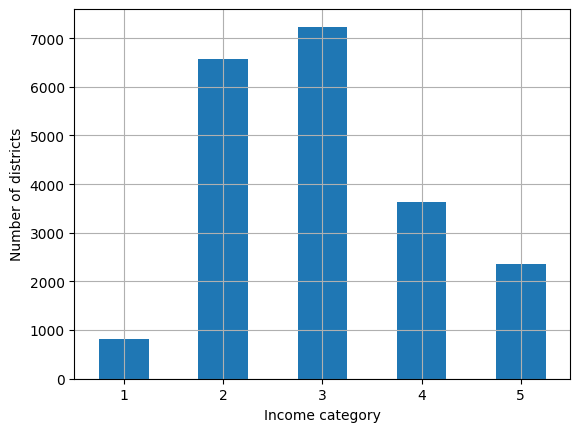

In [40]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()